## LSTM 구현하기
- **기울기 소실**문제는 RNN에 입력되는 문장 길이가 길수록, 즉 T가 길어질수록 발생할 수 밖에 없는 구조적인 문제. 따라서 이를 해결하기 위한 새로운 구조적 고민이 필요
- LSTM은 기존의 은닉층 & 출력에 해당하는 $h_t$에 더하여 오직 셀별 정보만을 저장, 기억하는 $c_t$를 추가적인 구조로 도입 + $c_t$를 구현하기 위한 **게이트**개념 도입


LSTM 모델
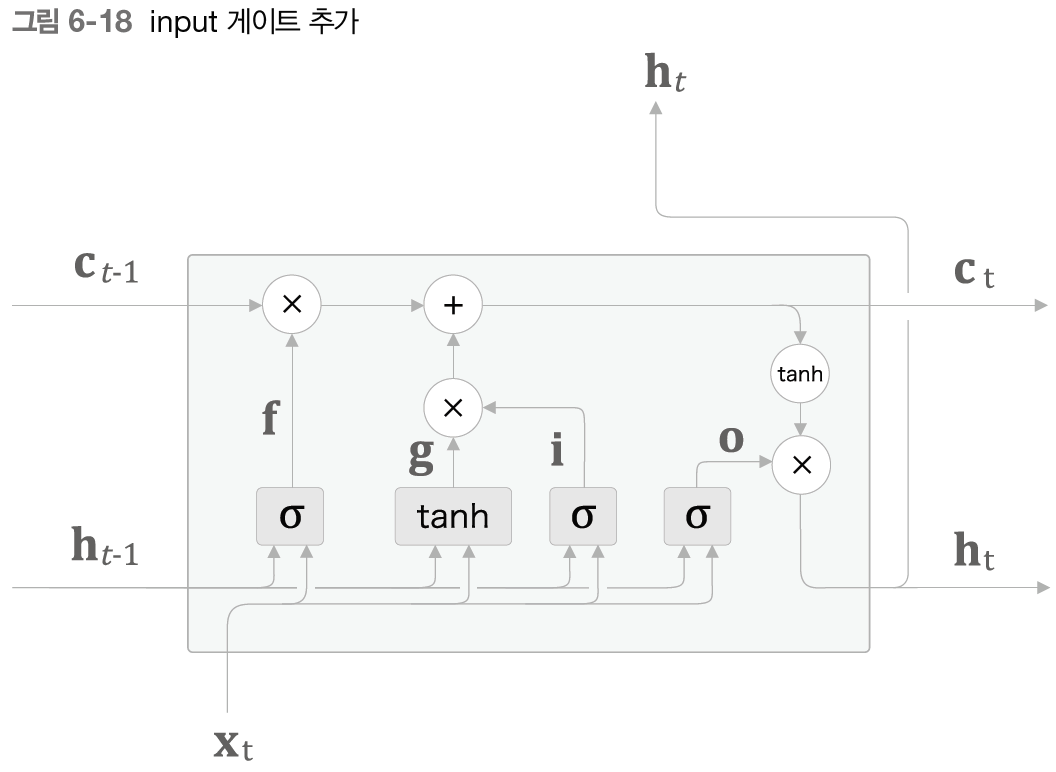
1) f (forget gate)  = $\sigma(X_tW_{x}^{(f)} + h_{t-1}W_{t}^{(f)} + b^{(f)})$
- $c_{t-1}$ 과 곱하여서 어떤 정보를 잃거나 유지할 것인지를 결정하는 역할을 하는 게이트

2) i (input gate) = $\sigma(X_tW_{x}^{(i)} + h_{t-1}W_{t}^{(i)} + b^{(i)})$
- t 시점의 데이터가 t-1시점과 비교하여 어떤 부분을 얼마나 가중하여 합할 것인지를 결정하는 게이트
- 셀 상태 업데이트 (Cell state update)단계에서 input gate가 tanh 와 행렬곱하여 $c_{t-1}$를 새로운 셀인 $c_{t}로 업데이트 한다

3) Cell state update
- g = $tanh(X_tW_{x}^{(i)} + h_{t-1}W_{t}^{(i)} + b^{(i)})$
- $c_t = f\odot c_{t-1} + g\odot i$

4) o (output gate) = $\sigma(X_tW_{x}^{(o)} + h_{t-1}W_{t}^{(o)} + b^{(o)})$
- 최종 출력하는 $h_t$를 계산하기 위해 사용되는 게이트
- $h_t = o \odot tanh(c_t)$

<br >

### 구현시 취할 방법
- f, i, g, o가 모두 동일한 구조를 취하고 가중치들 모두 $X_t, h_t$에 종속되므로 해당되는 가중치들을 **하나의 행렬안에 담아서** 사용 및 업데이트하는 방식을 이용하기


In [1]:
# LSTM class를 mh_time_layers.py에 구현하기
#역전파 관련하여 아래의 자료를 참조할것
#https://www.youtube.com/watch?v=qKgqrdrf224&ab_channel=KyungHoonHan -> 48분 35초부터

In [4]:
#LSTM 학습을 위한 Rnnlm 클래스 생성
import numpy as np
from mh_common.mh_time_layers import *

import sys
sys.path.append(r'C:\Users\myunghoon_k\OneDrive - UOS\bitamin\dl_nlp_study\deep-learning-from-scratch-2-master')
from common.base_model import BaseModel

class Rnnlm(BaseModel):
    def __init__(self, vocab_size = 10000, wordvec_size = 100, hidden_size = 100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        #가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        #계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = True),
            TimeAffine(affine_W, affine_b)
        ]
        
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        #가중치, 기울기
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout = 1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.11
| 에폭 1 |  반복 21 / 1327 | 시간 4[s] | 퍼플렉서티 2141.05
| 에폭 1 |  반복 41 / 1327 | 시간 8[s] | 퍼플렉서티 1140.69
| 에폭 1 |  반복 61 / 1327 | 시간 12[s] | 퍼플렉서티 915.91
| 에폭 1 |  반복 81 / 1327 | 시간 16[s] | 퍼플렉서티 702.72
| 에폭 1 |  반복 101 / 1327 | 시간 20[s] | 퍼플렉서티 604.31
| 에폭 1 |  반복 121 / 1327 | 시간 24[s] | 퍼플렉서티 614.55
| 에폭 1 |  반복 141 / 1327 | 시간 29[s] | 퍼플렉서티 582.54
| 에폭 1 |  반복 161 / 1327 | 시간 33[s] | 퍼플렉서티 550.39
| 에폭 1 |  반복 181 / 1327 | 시간 37[s] | 퍼플렉서티 568.41
| 에폭 1 |  반복 201 / 1327 | 시간 42[s] | 퍼플렉서티 497.86
| 에폭 1 |  반복 221 / 1327 | 시간 46[s] | 퍼플렉서티 495.21
| 에폭 1 |  반복 241 / 1327 | 시간 51[s] | 퍼플렉서티 453.52
| 에폭 1 |  반복 261 / 1327 | 시간 55[s] | 퍼플렉서티 479.84
| 에폭 1 |  반복 281 / 1327 | 시간 60[s] | 퍼플렉서티 469.13
| 에폭 1 |  반복 301 / 1327 | 시간 64[s] | 퍼플렉서티 418.29
| 에폭 1 |  반복 321 / 1327 | 시간 68[s] | 퍼플렉서티 358.92
| 에폭 1 |  반복 341 / 1327 | 시간 73[s] | 퍼플렉서티 419.03
| 에폭 1 |  반복 361 / 1327 | 시간 77[s] | 퍼플렉서티 432.84
| 에폭 1 |  반복 381 / 1327 | 시간 82[s] | 퍼플렉서티 365.06
| 에폭 1

C:\Users\myunghoon_k\OneDrive - UOS\bitamin\dl_nlp_study\mh_common\mh_functions.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


| 에폭 2 |  반복 1241 / 1327 | 시간 556[s] | 퍼플렉서티 186.75
| 에폭 2 |  반복 1261 / 1327 | 시간 560[s] | 퍼플렉서티 178.96
| 에폭 2 |  반복 1281 / 1327 | 시간 565[s] | 퍼플렉서티 180.30
| 에폭 2 |  반복 1301 / 1327 | 시간 569[s] | 퍼플렉서티 225.25
| 에폭 2 |  반복 1321 / 1327 | 시간 573[s] | 퍼플렉서티 218.63
| 에폭 3 |  반복 1 / 1327 | 시간 574[s] | 퍼플렉서티 225.96
| 에폭 3 |  반복 21 / 1327 | 시간 578[s] | 퍼플렉서티 207.38
| 에폭 3 |  반복 41 / 1327 | 시간 583[s] | 퍼플렉서티 204.21
| 에폭 3 |  반복 61 / 1327 | 시간 587[s] | 퍼플렉서티 181.47
| 에폭 3 |  반복 81 / 1327 | 시간 591[s] | 퍼플렉서티 168.69
| 에폭 3 |  반복 101 / 1327 | 시간 595[s] | 퍼플렉서티 160.09
| 에폭 3 |  반복 121 / 1327 | 시간 599[s] | 퍼플렉서티 174.99
| 에폭 3 |  반복 141 / 1327 | 시간 603[s] | 퍼플렉서티 183.89
| 에폭 3 |  반복 161 / 1327 | 시간 607[s] | 퍼플렉서티 204.07
| 에폭 3 |  반복 181 / 1327 | 시간 611[s] | 퍼플렉서티 209.68
| 에폭 3 |  반복 201 / 1327 | 시간 615[s] | 퍼플렉서티 201.97
| 에폭 3 |  반복 221 / 1327 | 시간 619[s] | 퍼플렉서티 203.80
| 에폭 3 |  반복 241 / 1327 | 시간 624[s] | 퍼플렉서티 194.75
| 에폭 3 |  반복 261 / 1327 | 시간 628[s] | 퍼플렉서티 202.05
| 에폭 3 |  반복 281 / 1327 | 시간 632

C:\ProgramData\Anaconda3\envs\torch_mh\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\envs\torch_mh\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\envs\torch_mh\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\envs\torch_mh\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\envs\torch_mh\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\envs\torch_mh\lib\site-package

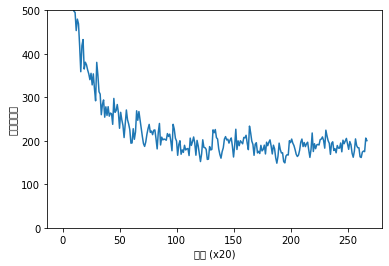

퍼플렉서티 평가 중 ...
0 / 235

C:\Users\myunghoon_k\OneDrive - UOS\bitamin\dl_nlp_study\mh_common\mh_functions.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


234 / 235
테스트 퍼플렉서티:  209.0252436455767


In [5]:
#Rnnlm 이용 LSTM 학습
from mh_common.mh_optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉층 차원 수
time_size = 35     # 시점의 수
lr = 20.0
max_epoch = 4
max_grad = 0.25

#데이터 불러오기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

#모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

#기울기 클리핑 적용
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
           eval_interval = 20)
trainer.plot(ylim = (0, 500))

#테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

#매개변수 저장
model.save_params()